# Processing the capillary force video
Use ffmpeg to export sheets
```sh
ffmpeg -i T-L\ _\ 1-50\ tip-tip.avi -r 20 output_%04d.png
```

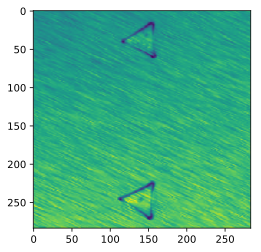

In [201]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import feature, io
im = io.imread('images/output_0001.png', as_grey=True)
imshow(im);

## Noise reduction

In [202]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma)

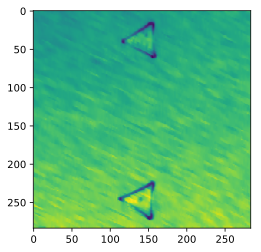

In [204]:
im2=denoise_tv_chambolle(im, weight=0.04, multichannel=True)
imshow(im2);

## Edge detection

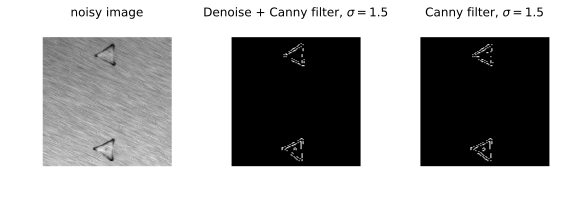

In [205]:
# Compute the Canny filter for two values of sigma
s=[1.5, 1.5]
edges1 = feature.canny(im2, sigma=s[0])
edges2 = feature.canny(im, sigma=s[1])

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image')

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Denoise + Canny filter, $\sigma={}$'.format(s[0]))

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma={}$'.format(s[1]))

fig.tight_layout()

plt.show()

## Major Axis
The major axis will go through both center of gravity, so it is used to find the connection line

In [206]:
def covmatrix(edges):
    '''Center of gravity + Covariance Matrix'''
    nx, ny=edges.shape
    n=sum(edges)
    ax=arange(nx)
    ay=arange(ny)
    x=sum(ax[:, newaxis]*edges)/n
    xx=sum(ax[:, newaxis]**2*edges)/n
    y=sum(ay[newaxis, :]*edges)/n
    yy=sum(ay[newaxis, :]**2*edges)/n
    xy=dot(dot(ax, edges), ay)/n
    lxx=xx-x**2
    lyy=yy-y**2
    lxy=xy-x*y
    return array([x, y]), array([[lxx, lxy],[lxy, lyy]])

In [97]:
def main_axis(edges):
    '''Diagonalize to find major axis with least eigenval'''
    center, covm=covmatrix(edges)
    val, vec=eigh(covm)
    A = np.random.random((3,3))
    eigenValues,eigenVectors = linalg.eig(A)

    idx = val.argsort()  
    val = val[idx]
    vec = vec[:,idx]
    return center[::-1], vec[0]

In [196]:
def get_axis(edges, show):
    center, slop=main_axis(edges)
    if show:
        imshow(edges)
        p=center+130*slop
        q=center-130*slop
        plot([p[0], q[0]], [p[1],q[1]]);
    return slop

In [239]:
def normalize(angle):
    if angle<0:
        angle+=2*pi
    return angle-pi/2
def detect_angle(num, show=False):
    fname='images/output_%04d.png'%num
    im = io.imread(fname, as_grey=True)
    im2=denoise_tv_chambolle(im, weight=0.05, multichannel=True)
    edges = feature.canny(im2, sigma=1.5)
    return normalize(arctan2(*get_axis(edges, show)))

The angle is relative to the right $\rightarrow$ direction

1.5687151953255642

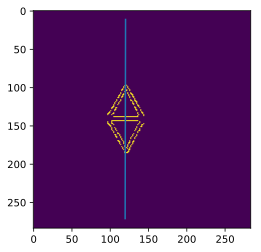

In [245]:
detect_angle(51, show=True)

In [241]:
%time angles=[detect_angle(i+1) for i in range(51)]

CPU times: user 9.04 s, sys: 151 µs, total: 9.04 s
Wall time: 9.03 s


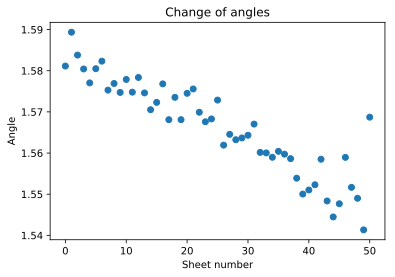

In [244]:
plot(angles, 'o')
title('Change of angles')
xlabel('Sheet number')
ylabel('Angle');